# Assignment 4

Welcome to the final assignment for CS188 Computer Vision course!

We are pleased that you have made it this far and are excited to see what you will accomplish in this last challenge.

Before we get started, please type your information below.

In [1]:
!nvidia-smi

Mon Mar 18 04:10:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#@title Your Info { display-mode: "form" }

Name = 'Brody Jones'  #@param {type:"string"}
UID = '905762155'  #@param {type:"string"}

## Notice

This assignment is meant to be exploratory and is designed to be relatively straightforward compared to previous assignments. Our goal is to provide you with an opportunity to review and apply the concepts you have learned so far in a more flexible and creative manner, while also allowing you to focus on your project and prepare for the upcoming finals.

We encourage you to think critically and creatively as you work through this assignment, and to use this opportunity to dive deeper into the material we have covered. As always, if you have any questions or concerns, please don't hesitate to reach out to the course staff. We are here to support you throughout the process.

Best of luck with the rest of the quarter!

## Goals


In this assignment, you will have the opportunity to explore two applications of deep learning for computer vision:

1. Diffusion Models
2. Neural Radiance Fields (NeRFs)

Through this assignment, you will first gain experience in building a diffusion model from scratch and understanding the state-of-the-art StableDiffusion text-to-image diffusion model. Additionally, you will delve into the concept of neural radiance fields (NeRFs) and use them to represent a single large image with a neural network. Finally, you will explore advanced topics related to neural radiance fields.


As always, please feel free to post any questions or issues you encounter on the Piazza forum. And remember, please do not directly copy code from other sources.

This assignment is due on **Sunday, March 17th**. Best of luck with your work!

❗**Once you have finished all the questions, note that it may take approximately *60 minutes* to re-run the entire notebook to prepare the submission version. Make sure to allocate enough time for this task and start early.**

## Q0: Data Preparation(0 pts)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from tqdm import tqdm

### Setup Seeding

In [4]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(0)

### Setup Device

In [5]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


### Create Folder

In [6]:
import os

# Let's make our assignment directory
CS188_path = './CS188_W24'
os.makedirs(os.path.join(CS188_path, 'Assignment4', 'data'), exist_ok=True)
# os.makedirs will create directories recursively, i.e., it will create the
# directories and any missing parent directories if they do not exist.

# Now, let's specify the assignment path we will be working with as the root.
root_dir = os.path.join(CS188_path, 'Assignment4')


----
## Q1. Diffusion Model (50 pts)

A (denoising) diffusion model isn't that complex if you compare it to other generative models such as Normalizing Flows, GANs or VAEs: they all convert noise from some simple distribution to a data sample. This is also the case here where **a neural network learns to gradually denoise data** starting from pure noise.

In a bit more detail for images, the set-up consists of 2 processes:
* a **fixed** (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* a **learned** reverse denoising diffusion process $p_\theta$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

Both the forward and reverse process indexed by $t$ happen for some number of finite time steps $T$. You start with $t=0$ where you sample a real image $\mathbf{x}_0$ from your data distribution (let's say an image of a cat from ImageNet), and the forward process samples some noise from a Gaussian distribution at each time step $t$, which is added to the image of the previous time step. Given a sufficiently large $T$ and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) at $t=T$ via a gradual process.

Let's write this down more formally, as ultimately we need a tractable loss function which our neural network needs to optimize.

Let $q(\mathbf{x}_0)$ be the real data distribution, say of "real images". We can sample from this distribution to get an image, $\mathbf{x}_0 \sim q(\mathbf{x}_0)$. We define the forward diffusion process $q(\mathbf{x}_t | \mathbf{x}_{t-1})$ which adds Gaussian noise at each time step $t$, according to a known variance schedule $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ as
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathbf{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}).
$$

Recall that a normal distribution (also called Gaussian distribution) is defined by 2 parameters: a mean $\mu$ and a variance $\sigma^2 \geq 0$. Basically, each new (slightly noiser) image at time step $t$ is drawn from a **conditional Gaussian distribution** with $\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}$ and $\sigma^2_t = \beta_t$, which we can do by sampling $\mathbf{\epsilon} \sim \mathbf{N}(\mathbf{0}, \mathbf{I})$ and then setting $\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}$.

Note that the $\beta_t$ aren't constant at each time step $t$ (hence the subscript) --- in fact one defines a so-called **"variance schedule"**, which can be linear, quadratic, cosine, we will be using linear variance schedule in this assignment.

So starting from $\mathbf{x}_0$, we end up with $\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T$, where $\mathbf{x}_T$ is pure Gaussian noise if we set the schedule appropriately.

Now, if we knew the conditional distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$, then we could run the process in reverse: by sampling some random Gaussian noise $\mathbf{x}_T$, and then gradually "denoise" it so that we end up with a sample from the real distribution $\mathbf{x}_0$.

However, we don't know $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$. It's intractable since it requires knowing the distribution of all possible images in order to calculate this conditional probability. Hence, we're going to leverage a neural network to **approximate (learn) this conditional probability distribution**, let's call it $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$, with $\theta$ being the parameters of the neural network, updated by gradient descent.

Ok, so we need a neural network to represent a (conditional) probability distribution of the backward process. If we assume this reverse process is Gaussian as well, then recall that any Gaussian distribution is defined by 2 parameters:
* a mean parametrized by $\mu_\theta$;
* a variance parametrized by $\Sigma_\theta$;

so we can parametrize the process as
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathbf{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
where the mean and variance are also conditioned on the noise level $t$.

For more detailed mathematical analysis of diffusion models, refer to this wonderful [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models).

Our implementation would be based on one of the most influential papers of diffusion models [DDPM](https://arxiv.org/abs/2006.11239) by Ho. et al., feel free to also check the original paper. Note that the field of diffusion models is evolving rapidaly in recent years with a lot tips of tricks, and we will explore one state-of-the-art diffusion model [StableDiffusion](https://stability.ai/) in Q1.4.


Here we use the classical MNIST dataset. MNIST consists of images with hand-written digits from 0 to 9, which is the most well-known benchmark for image classification and generation tasks. We apply random horizontal flips and rescaling and on the input images to make them have values in the $[-1,1]$ range. We use random horizontal flips during training to improve sample quality slightly.

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

image_size = 32
channels = 1
batch_size = 128

# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

# load dataset from the hub
dataset = MNIST(root=f"{root_dir}/data", transform=transform, download=True)

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 91672167.07it/s]


Extracting ./CS188_W24/Assignment4/data/MNIST/raw/train-images-idx3-ubyte.gz to ./CS188_W24/Assignment4/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39586828.05it/s]


Extracting ./CS188_W24/Assignment4/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./CS188_W24/Assignment4/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32610746.23it/s]


Extracting ./CS188_W24/Assignment4/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./CS188_W24/Assignment4/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23490171.11it/s]


Extracting ./CS188_W24/Assignment4/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./CS188_W24/Assignment4/data/MNIST/raw



### Q1.1: Forward process = Noise scheduler (15 pts)
We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form to calculate the image for any of the timesteps individually.

A nice property of the above process is that we can sample $\mathbf{x}_t$ at any arbitrary time step $t$ in a closed form using reparameterization trick.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$:
$$ \begin{aligned} \mathbf{x}_t &= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} \text{; where} \ \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathbf{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}
\\
\text{Hence, }q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathbf{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I}) \end{aligned} $$



(*) Recall that when we merge two Gaussians with different variance, $\mathbf{N}(\mathbf{0}, \sigma_1^2\mathbf{I})$ and $\mathbf{N}(\mathbf{0}, \sigma_2^2\mathbf{I})$, the new distribution is $\mathbf{N}(\mathbf{0}, (\sigma_1^2 + \sigma_2^2)\mathbf{I})$. Here the merged standard deviation is $\sqrt{(1 - \alpha_t) + \alpha_t (1-\alpha_{t-1})} = \sqrt{1 - \alpha_t\alpha_{t-1}}$.

Usually, we can afford a larger update step when the sample gets noisier, so $\beta_1 \lt \beta_2 \le \dots \lt \beta_T$ and therefore $\bar{\alpha}_1 \gt \dots \gt \bar{\alpha}_T$.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

Let's implement the forward process in the code blocks below:

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


# Define beta schedule
# Feel free to try other T and schedulers
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
################# Your Implementations #########################################
# TODO: precompute the following variables using the above equations
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
# alphas_cumprod_prev = torch.cat([torch.tensor([1.]), alphas_cumprod[:-1]])
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
################# End of your Implementations ##################################


def get_index_from_list(vals, t):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, 1, 1, 1).to(t.device)


@torch.no_grad()
def forward_diffusion_sample(x_0, t):
    """
    Perform the forward diffusion process
    x0: input image of shape [B, C, H, W]
    t: input timesteps of shape [B]
    use the provided "get_index_from_list" function to get values at timestep t
    returns:
    x_t: noisy image at time step t of shape [B, C, H, W]
    noise: the generated gaussian noise
    """
    x_t = None
    noise = None
    ################# Your Implementations #####################################


    x_t = get_index_from_list(sqrt_alphas_cumprod, t) * x_0 + get_index_from_list(sqrt_one_minus_alphas_cumprod, t) * torch.randn_like(x_0)
    noise = torch.randn_like(x_t)


    ################# End of your Implementations ##############################
    return x_t, noise

Let's test it on our dataset.
If your implentation is correct, you should see the image is gradually becoming noiser and becomes a complete random noise in the final steps.

<ipython-input-9-5fc168999004>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, 1)


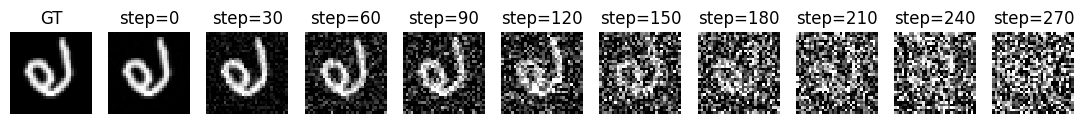

In [9]:
def show_tensor_image(image, title):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.axis("off")
    plt.title(title)
    image = torch.clamp(image, -1.0, 1.0)
    plt.imshow(reverse_transforms(image), cmap="gray", interpolation='none')


# Simulate forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10 + 1
stepsize = int(T / (num_images - 1))
plt.subplot(1, num_images + 1, 1)
show_tensor_image(image, "GT")
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 2)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img, f"step={t.item()}")

### Q1.2: Backward process = U-Net (15 pts)





Empirically, DDPM found that training objective of the diffusion model $\mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t)$ is equivalent to predicting the noise $\epsilon_\theta(\mathbf{x}_{t},t)$ at timestamp t, which is easier for the model to learn i.e.,  

$$
\begin{aligned}
L &= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t}[|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)|^2 ]
\\  
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} [|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)|^2 ]
\end{aligned}
$$

We can use a U-Net model to model the noise $\epsilon_\theta(\mathbf{x}_{t},t)$.

The training algorithm now looks as follows:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In other words:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

In reality, all of this is done on batches of data as one uses stochastic gradient descent to optimize neural networks.

**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the output is the **noise** in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The timestep is encoded by the transformer Sinusoidal Embedding

U-Net consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet). The architecture of the U-Net would be as follows:

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="600" />
</p>

As can be seen, a U-Net model first downsamples the input (i.e. makes the input smaller in terms of spatial resolution), after which upsampling is performed. Let's implement a simple U-Net in the following code block:


In [10]:
import math


class Block(nn.Module):
    """
    A baisc U-Net block.
    """

    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 2, 2, 0)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.MaxPool2d(2, 2, 0)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(
            torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = channels
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = channels
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU())

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        ################# Your Implementations #################################
        # TODO: initialize the u-net
        # 1. Define downsample blocks according to down_channels
        # 2. Define upsample blocks according to up_channels
        # Hint: Use torch.nn.ModuleList instead of the standard python list to
        #       ensure that your blocklist will be stored properly as nn.Module

        self.downblock = torch.nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)
        ])
        self.upblock = torch.nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)
        ])


        ################# End of your Implementations ##########################

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        print(timestep.device)
        print("check 1")
        t = self.time_mlp(timestep).to(x.device)
        print("check 2")
        print(t.device)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        ################# Your Implementations #################################
        # 1. Downsample, store intermediate features to residual_inputs
        # 2. Concat the outputs with the intermediate features stored in residual_input, then Upsample

        residual_inputs = []
        for down in self.downblock:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.upblock:
            x = up(x + residual_inputs.pop(), t)


        ################# End of your Implementations ##########################
        return self.output(x)

In the following code block, implement the loss function between the target noise and the predicted noise

In [11]:
def get_loss(model, x_0, t):
    """
    x_0: initial image without noise [B, C, H, W]
    t: timestamp [B]
    """
    loss = None
    ################# Your Implementations #####################################
    # 1. Perform forward diffusion process to get the target noise and the noisy image
    # 2. Perform denoising step on the noisy image to get the predicted noise from the model
    # 3. Compute the loss from the predicted and the the target noise
    # 4. You could experiment with both l1 and l2 losses, in practice, l1 loss gives better quality, while l2 loss gives more diversity
    x_t, target_noise = None, None
    x_t, target_noise = forward_diffusion_sample(x_0, t)
    pred_noise = SimpleUnet(x_t, t) ## check this again
    loss = torch.nn.functional.l1_loss(pred_noise, target_noise)


    ################# End of your Implementations ##############################
    return loss

### Q1.3: Sampling (10 pts)



Sampling is summarized in DDPM as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

Following Algorithm 2, implement the sampling procedure below.


In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    x: input image at timestamp t [B, C, H, W]
    t: the timestamp [B]
    """
    x_denoised = None
    ################# Your Implementations #####################################
    # 1. Calculate the predicted noise at timestamp t with the trained model
    # 2. Denoise the image at timestamp t with the predicted noise according to the above algorithm
    # 3. If we are not in the last step yet, apply random gaussian noise to the denoised image to get the image at timestamp t-1.
    # Note that the algorithm starts at t=1, and in our implementation we start at t=0
    unet = SimpleUnet()
    # unet.eval()
    # x_t, target_noise = forward_diffusion_sample(x, t)
    pred_noise = unet.forward(x, t)
    alpha_t = get_index_from_list(alphas, t)
    x_denoised = 1/torch.sqrt(alpha_t) * (x - ((1 - alpha_t)*pred_noise / sqrt_one_minus_alphas_cumprod))
    if t >= 0:
        x_denoised = x_denoised + torch.randn_like(x_denoised)



    ################# End of your Implementations ##############################
    return x_denoised


@torch.no_grad()
def sample_plot_image():
    # Sample noise
    model.eval()
    img = torch.randn((1, channels, image_size, image_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu(), f"step={t.item()}")
    plt.show()
    model.train()

Now we have finished all components required to train diffusion models, it's time to train our model on the MNIST dataset!

Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

cuda:0
check 1


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

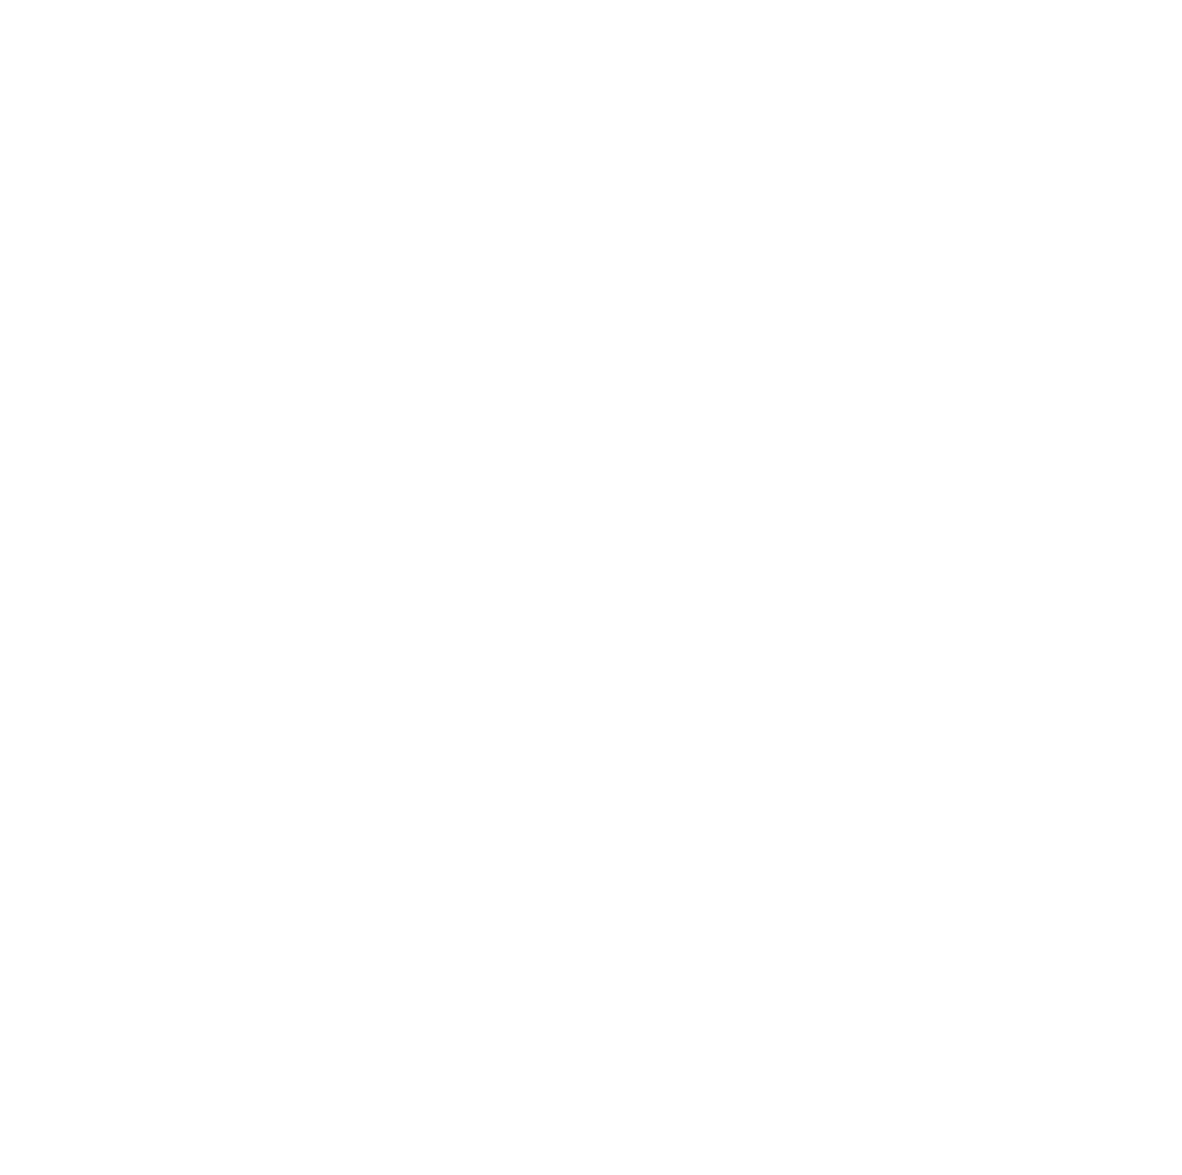

In [13]:
from torch.optim import Adam

# feel free to try different seeds
seed_everything(0)

model = SimpleUnet()
model.to(device)

# feel free to try other optimizers, lrs and epochs
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    with tqdm(total=len(dataloader),
              desc=f'Epoch {epoch + 1}/{epochs}',
              position=0,
              leave=True) as pbar:
        for step, batch in enumerate(dataloader):
            images = batch[0]
            images = images.to(device)
            if step == 0:
                sample_plot_image()
            optimizer.zero_grad()

            t = torch.randint(0, T, (images.shape[0], ), device=device).long()
            loss = get_loss(model, images, t)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

You may want to generate more samples from the trained model to check its  diversity and quality. For example, I got the following generated "3" with my model. You can sample several times and leave the one that you're most satisfied with.


<img src="https://drive.google.com/uc?id=1OUcJ0P798XaDnp8XnU8U2EycA41SCXYN" width="800" />

cuda:0
check 1


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

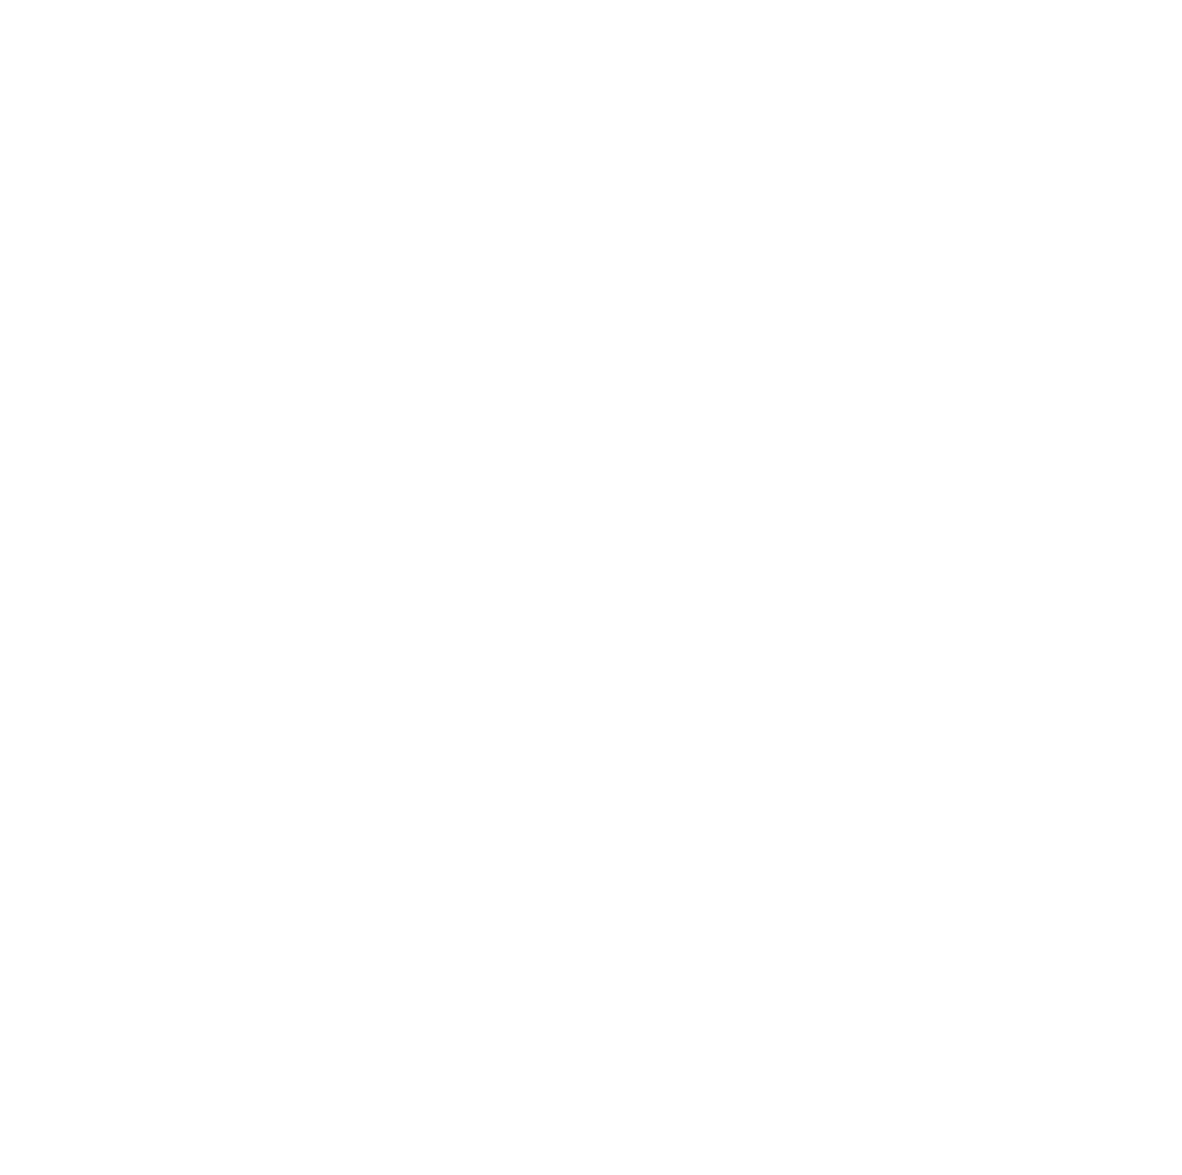

In [14]:
sample_plot_image()

### Q1.4 State-of-the-art Diffusion Models (10 pts)

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

In this question, let's see how to use Stable Diffusion with the Hugging Face [Diffusers library](https://github.com/huggingface/diffusers).


In [14]:
!pip install diffusers==0.11.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.





<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

We already implemented the U-Net in the previous questions.

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. In the previous questions, we have implemented the [DDPM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) in our simple diffusion model. For Stable Diffusion, we will use [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py).

Theory on how the scheduler algorithm function is out of scope for this assignment, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's get into the code!

We will start by loading the individual models involved.

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [35]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Now we define the scheduler for the denoising process using the PNDM scheduler.

In [36]:
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4",
                                          subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Next we move the models to the GPU.

In [37]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

We now define the parameters we'll use to generate images.

`prompt` defines the text that the generation is conditioned on.

`heigt` and `width` are the default size of the image during training so there's no need for modification.

`num_inference_steps` defines the total number of denoising steps.

`guidance_scale` is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. It forces the generation to better match with the prompt. Numbers like 7 or 8.5 give good results, if you use a very large number the images might look good, but will be less diverse.

`generator` defines the seed that we would like to use when creating the initial random noise, which can be crucial for the generation results as well.

In [105]:
################# Your Implementations #########################################
#TODO: play with the prompt, inference_steps, guidance scales and seed
prompt = ["a photograph of several boats on a river"
          ]  # try different prompts

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 100  # try numbers like 1, 10, 50

guidance_scale = 7.5  # try numbers like 0, 1, 75

generator = torch.manual_seed(16)  # try different seeds as well

################# End of Your Implementations ##################################

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [106]:
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [107]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size,
                         padding="max_length",
                         max_length=max_length,
                         return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [108]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise. That is similar to what we have done before, except that in StableDiffusion we directly generate the noise in the latent space instead of the image space.

In [109]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(device)

The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [110]:
scheduler.set_timesteps(num_inference_steps)

We are ready to write the denoising loop.

In [111]:
from torch import autocast
from tqdm.auto import tqdm

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input,
                          t,
                          encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text -
                                                       noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/101 [00:00<?, ?it/s]

We now use the `vae` to decode the generated `latents` back into the image.

In [112]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

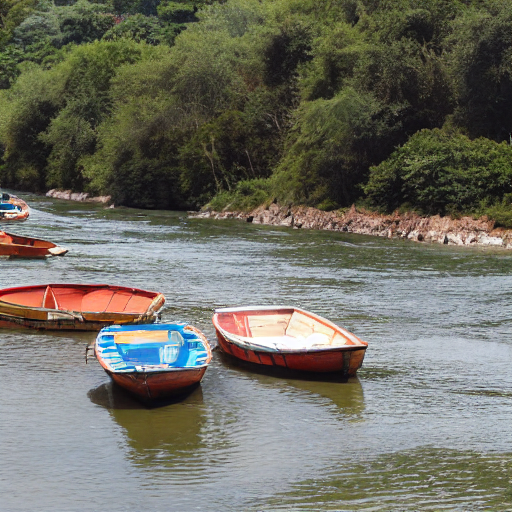

In [113]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Play around with the different hyperparameters of StableDiffusion including the prompt, num_inference_steps, guidance_scale, and generator, describe how the generated image would change based on the hyperparametes, feel free to add some code blocks below to show your generated images.

(Double click to edit)

Your Answer: I initially tested various prompts, with the initial parameters, our model was able to generate realistic images for most all prompts.  Changing the number of inference steps will alter how far along the generative process out model will step before outputting a final image.  Increasing this will help image quality (with diminishing returns for larger numbers) and dropping this down to 10 will give us a much blurrier, less developed, but still passable image.  1 inference step give a nonsensical output. Guidance scale has a similar effect, indicating how our guidance effects noise prediction.  A scale of 0 outputs a random img completely unrelated to the prompt, even on many steps, and a scale of 1 will make it recognizable, but still sloppy.  Setting guidance scale to 75 goes too far and generated oversaturated, grainy, hyperstylized pictures; 7.5 was a good sweet spot. Changing the seed will generated a new image based on the prompt with a different scene, but same image quality.

---

# Q2. Neural Fields (50 pts)


What are neural fields?

Neural fields are a class of neural network models that are designed to operate on continuous inputs, and are often used in image and signal processing tasks.

They are based on the idea of representing the input space as a continuous field of neurons, which can be used to represent an image or a signal! Essentially, they use a single neural network to represent the entire input space.

In this section, we will explore the use of neural fields for image representation and scene reconstruction. We will cover some basic concepts here.

### Q2.1 Neural Fields as Image representation (25 pts)

The core idea behind neural fields is to use a single neural network, typically a multi-layer perceptron (MLP), to represent an entire image.

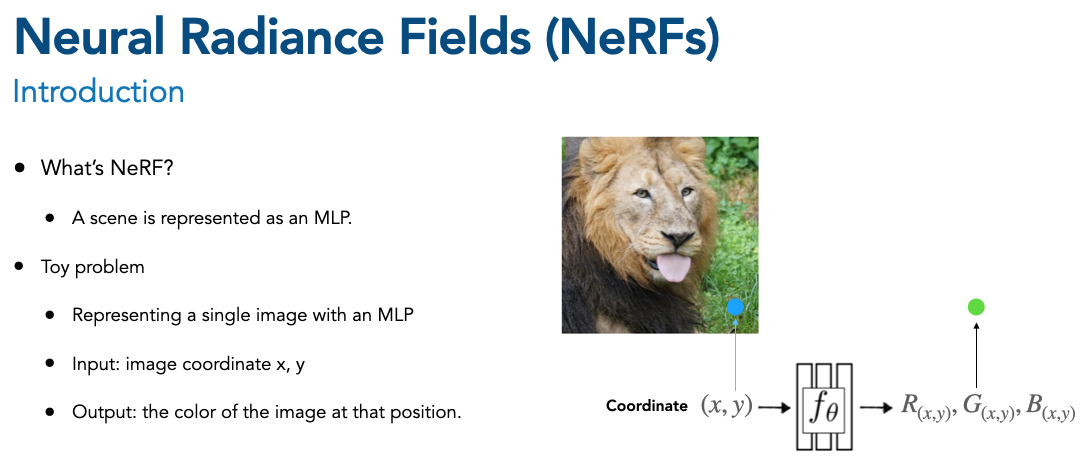

Let's do the first toy problem: representing an image as a NeRF.

In [15]:
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import requests

We will use this image as an example

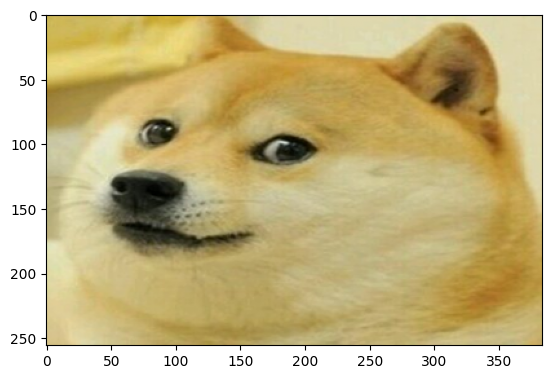

In [16]:
# Download image, take a square crop from the center
img_url = 'https://raw.githubusercontent.com/UCLAdeepvision/CS188-Assignments-2024Winter/main/Assignment4/assets/doge.jpeg'
img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
img = img.resize((384, 256))
img = np.array(img) / 255.

plt.imshow(img)
plt.show()

#### Q2.1.1 Continuous input space (5 pts)

Our neural fields can take in continuous inputs, although not absolutely continuous. For example, here we treat image coordinates as inputs, which are continuous in real-world but discrete in camera sensor.

Let's define a `make_grid` function.

In [17]:
def make_grid(img_shape):
    """
    Create a grid of pixel coordinates in the unit square for a given image shape.

    Args:
        img_shape (tuple): The width, height, and number of channels of the image.

    Returns:
        numpy.ndarray: An array of pixel coordinates with shape (height, width, 2),
        where the last dimension contains the x and y coordinates of each pixel in the unit square.
    """
    grid = None
    ######## Your implementation ############
    # Hint: use np.linspace, np.stack, and np.meshgrid

    x = np.linspace(0, 1, img_shape[1])
    y = np.linspace(0, 1, img_shape[0])
    grid = np.meshgrid(x, y)
    grid = np.stack(grid, axis=2)


    ######## End of Your implementation ############
    # Return the grid of pixel coordinates
    return grid


In [18]:
x_test = make_grid(img.shape)
print(x_test[0, :2])
print(x_test[-1, -2:])
test_data = [torch.tensor(x_test).float(), torch.tensor(img).float()]
# Let's use only one fourth pixels as the training data
train_data = [torch.tensor(x_test[::2, ::2]).float(), torch.tensor(img[::2, ::2]).float()]

[[0.         0.        ]
 [0.00261097 0.        ]]
[[0.99738903 1.        ]
 [1.         1.        ]]


If your implementation is correct, you will get something similar to:
```
[[0.         0.        ]
 [0.00260417 0.        ]]
[[0.99479167 0.99609375]
 [0.99739583 0.99609375]]
```

#### Q2.1.2 MLP representation (8 pts)

We now construct a simple MLP that represents the original image.

Finish the `SimpleMLP` below, which should be very easy for you after so much training we have until now.

In [19]:
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, net_dim, num_layers):
        super(SimpleMLP, self).__init__()

        # create a list to store the layers of the MLP
        ############# Your Implementation here #############
        # Your tasks:
        #    1. Create a fc layer with in_dim as input and net_dim as output.
        #    2. Create (num_layers - 2) fc layers, all with `net_dim` in and `net_dim` out,
        #          and ReLU activation function.
        #    3. Create a final fc layer with `net_dim` number of input features
        #         and 3 output features (3 RGB channels),
        #         and a Sigmoid activation function (normalized RGB values).
        # Hint: You can use torch.nn.Sequential to link your layers together

        self.fc1 = nn.Linear(in_dim, net_dim)
        self.fc2 = torch.nn.ModuleList([
            nn.Linear(net_dim, net_dim) for _ in range(num_layers - 2)
        ])
        self.fc3 = nn.Linear(net_dim, 3)
        self.sigmoid = nn.Sigmoid()


        ############# End of Your Implementation #############


    def forward(self, x):
        out = None
        ############# Your Implementation here #############
        # Implement the forward pass, taking in a coordinate 'x'
        # as input, and returning the RGB value for that coordinate
        # in variable 'out'

        out = self.fc1(x)
        for layer in self.fc2:
            out = layer(out)
        out = self.fc3(out)
        out = self.sigmoid(out)


        ############# End of Your Implementation #############
        return out

Please read the `train_model` function below and try to interpret the steps by yourself.

In [20]:
mse2psnr = lambda mse_loss: -10 * torch.log10(2. * mse_loss).cpu().numpy()

def train_model(model, optimizer, criterion, iters, train_data, test_data, device):
    # Move the training and testing data to the specified device (e.g. CPU or GPU)
    train_data = [x.to(device) for x in train_data]
    test_data = [x.to(device) for x in test_data]

    # Initialize lists to store training and testing results
    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    # Loop over the specified number of training iterations
    with tqdm(total=iters, desc='train iter') as pbar:
        for i in range(iters):
            # Reset the gradients of the optimizer
            optimizer.zero_grad()

            # Forward pass through the model to obtain predictions
            pred = model(train_data[0])

            # Compute the loss between the predictions and the training data
            loss = criterion(pred, train_data[1])

            # Backward pass through the model to compute gradients
            loss.backward()

            # Update the model parameters using the optimizer
            optimizer.step()
            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())
            # Every 25 iterations, compute and store the training and testing PSNRs,
            # as well as the predicted images and iteration numbers
            if i % 25 == 0:
                with torch.no_grad():
                  train_psnrs.append(mse2psnr(loss))
                  pred_img = model(test_data[0])
                  test_mse_loss = criterion(pred_img, test_data[1])
                  test_psnrs.append(mse2psnr(test_mse_loss))
                  pred_imgs.append(pred_img.cpu().numpy())
                  xs.append(i)

    # Return the training and testing results as a dictionary
    return {
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }


Let's see how well this MLP works.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4
iters = 5000
criterion = nn.MSELoss()

model = SimpleMLP(2, 256, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
output_dict = train_model(model, optimizer, criterion, iters, train_data, test_data, device)

train iter: 100%|██████████| 5000/5000 [00:48<00:00, 103.26it/s, loss=0.0217]


Visualize the results

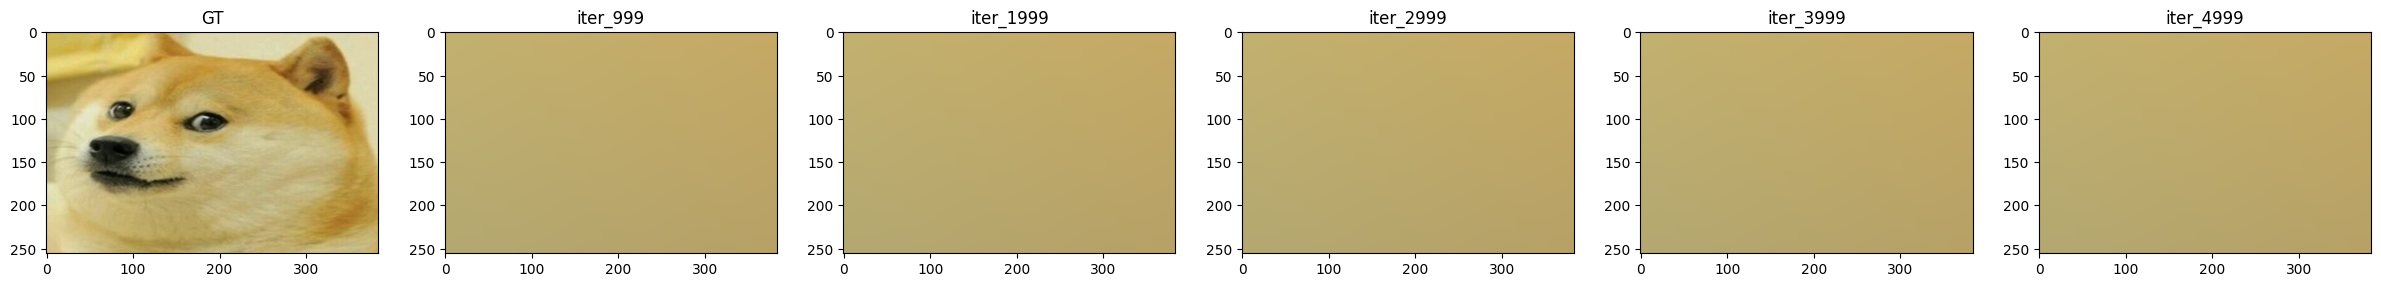

In [22]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title('GT')

selected_indexs = np.arange(999, 5000, 1000)
for i, idx in enumerate(selected_indexs):
    plt.subplot(1, 6, i+2)
    plt.imshow(output_dict['pred_imgs'][idx//25])
    plt.title(f'iter_{idx}')
plt.show()

Are your results super blurry? Those are expected. This is what we call "spectral bias", referring to the inherent problems with neural nets that they cannot model complex signals from low frequency information (only x, y coordinates).

To overcome this, we need to add high-frequency inputs to MLP via positional encoding.

#### Q2.1.3 Positional Encoding (10 pts)

Neural radiance fields require an efficient way of representing the input coordinate information to the network. Positional encoding is a technique used to map the input coordinate into a higher dimensional space using a series of sine and cosine functions of different frequencies.

We can this formula:

$\gamma(p)=\left(p, \sin\left(2^0 \cdot p\right), \cos\left(2^0 \cdot p\right), ...,\sin\left(2^{L-1} \cdot p\right), \cos\left(2^{L-1} \cdot p\right) \right)$,

Here, $p$ denotes the input coordinate, which could be a 2D image coordinate (x, y) or a 3D space coordinate (x, y, z). The parameter $L$ controls the number of frequency components used in the encoding. (We abbreviate $\pi$ here, which is included in the slides)

By using positional encoding, the network can effectively capture the spatial information of the input and learn the complex functions required for accurate rendering.






In [53]:
def pos_enc(x, num_freq_bands):
    """
    Computes positional encoding of input coordinates using sin/cos of different frequencies.

    Args:
        x (torch.Tensor): Input coordinate tensor of shape (..., d),
            where d is the number of dimensions (2 for 2D images, 3 for 3D volumes).
            Here `...` means all the former dimensions can be arbitrary.
        num_freq_bands (int): Number of frequency bands used for sin/cos of different frequencies.
            Also the `L` parameter in the formula above.

    Returns:
        torch.Tensor: Output tensor of shape (..., d + d * 2 * num_freq_bands),
            where the additional d*2*num_freq_bands dimensions correspond to frequency features.
            Any idea why? hint: cosine, sine for each input dimension and each frequency
    """
    output = None
    ########### Your implementation ##############
    # Your task:
    #   1. Create frequency bands using powers of 2, controled by the num_freq_bands.
    #   2. Compute the frequency-encoded coordinates using sin/cos function.
    #        Hint: you can use a single sine function to compute cosine as well.
    #   3. Concatenate the input and frequency features and return the result
    d = x.shape[-1]
    for i in range(d):
      for p in x[..., i]:
        # print(p.shape)
        freq_bands = torch.tensor([(2.0 ** i) for i in range(num_freq_bands)]).to(x.device)
        p_bands = p[i] * freq_bands
        print(freq_bands)
        sines = torch.sin(p_bands)
        cosines = torch.cos(p_bands)



    ########## End of Your implementation ##########

    return output


In [93]:
tmp_example = pos_enc(train_data[0], 8)
# print(tmp_example.shape, tmp_example[15,15])

If your implementation is correct, you would get outputs similar to:
```
torch.Size([128, 192, 34]) tensor([ 0.0781,  0.1172,  0.0780,  0.1169,  0.9969,  0.9931,  0.1556,  0.2322,
         0.9878,  0.9727,  0.3074,  0.4518,  0.9516,  0.8921,  0.5851,  0.8061,
         0.8110,  0.5918,  0.9490,  0.9541,  0.3153, -0.2995,  0.5985, -0.5716,
        -0.8011, -0.8206, -0.9589,  0.9380,  0.2837,  0.3466, -0.5440,  0.6503,
        -0.8391, -0.7597])
```

#### Q2.1.4 Compute the input dimension (2 pt)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4
iters = 5000
criterion = nn.MSELoss()

num_frequency_bands = 8
# Positional encoding
train_data_encoded = [pos_enc(train_data[0], 8), train_data[1]]
test_data_encoded = [pos_enc(test_data[0], 8), test_data[1]]

input_dim = None
########### Your implementation ##############
# compute the input_dim

input_dim = train_data_encoded[0].shape[-1] + train_data_encoded[1].shape[-1]

########## End of Your implementation ##########


model = SimpleMLP(input_dim, 256, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_enc_output_dict = train_model(
    model, optimizer, criterion, iters,
    train_data_encoded, test_data_encoded, # use frequency-encoded coords
    device)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 6, 1)
plt.imshow(img)
plt.title('GT')

selected_indexs = np.arange(999, 5000, 1000)
for i, idx in enumerate(selected_indexs):
    plt.subplot(2, 6, i+2)
    plt.imshow(output_dict['pred_imgs'][idx//25])
    plt.title(f'no_pos iter_{idx}')

for i, idx in enumerate(selected_indexs):
    plt.subplot(2, 6, i+8)
    plt.imshow(pos_enc_output_dict['pred_imgs'][idx//25])
    plt.title(f'pos_enc iter_{idx}')
plt.show()

Are the results better?

You may still find the results blur because the positional encoding used here, called axis-aligned encoding, is not a perfect one.

Although this encoding provides a way to incorporate positional information into the NeRF network, the results may still be blurry in some cases. But in practice, people just find this encoding is good enough for 3D scenes (where NeRF is originally proposed for).

If you're interested in exploring alternative positional encoding techniques, read this paper: [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739). which proposes a method for encoding spatial information using Fourier features. This technique has been shown to outperform the axis-aligned encoding in certain cases, and may be useful for more complex scenes.


## Q2.2 Simple NeRF (25 pts)

In this section, we will delve into the fundamental components of NeRF (Neural Radiance Fields), a recently developed method for 3D reconstruction and rendering from 2D images.

By studying these basic components, you will gain insight into the training process for NeRF and how it can be used to generate high-quality 3D reconstructions.

Before we get started, we highly recommend you to browse the project pages here:
1. https://www.matthewtancik.com/nerf
2. https://www.matthewtancik.com/learnit

and appreciate the beautiful rendered scenes there.

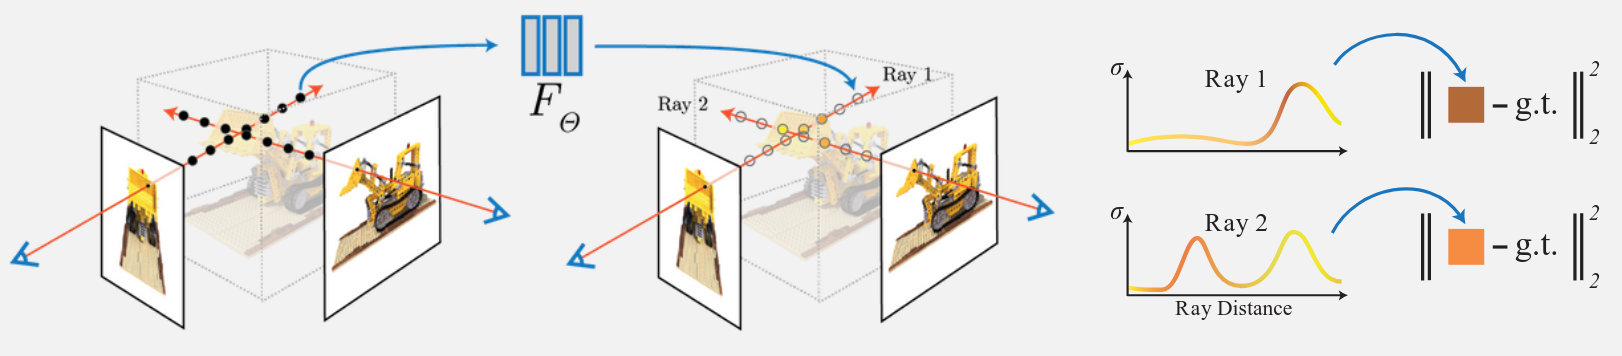

In [55]:
from tqdm.notebook import tqdm as tqdm
import os
import cv2
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import imageio
from tqdm import trange
from IPython.display import HTML
from base64 import b64encode

! pip install --quiet scenepic
! pip install --quiet imageio-ffmpeg

# Have to upgrade gdown to successfully download the file in colab.
! pip install --quiet --upgrade gdown
os.makedirs('/content/NeRF', exist_ok=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.6/669.6 kB 4.0 MB/s eta 0:00:00


--2024-03-18 04:46:52--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-03-18 04:46:52--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  22.5MB/s    in 0.5s    

2024-03-18 04:46:53 (22.5 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

focal: 138.88887889922103
(100, 100, 100, 3) (6, 100, 100, 3)
(100, 4, 4) (6, 4, 4)


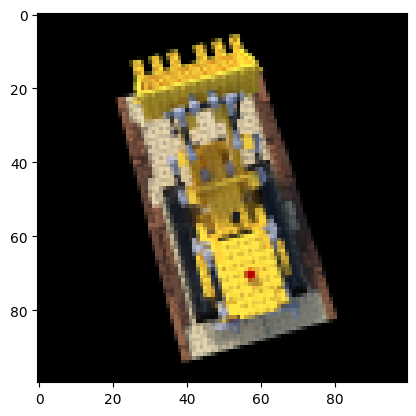

In [56]:
# Download the preprocessed lego scene
if not os.path.exists('/content/NeRF/tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
    !mv tiny_nerf_data.npz /content/NeRF/
else:
    print('File exists, skip')

data = np.load('/content/NeRF/tiny_nerf_data.npz')
images = data['images']
# These parameters are kind of outside the scope of this course.
# They will be covered in 3D vision courses.
# If you're interested, feel free to reach out to our TAs.

poses = data['poses']    # camera to world matrix

focal = data['focal']     # assume focal x and focal y are the same
H, W = images.shape[1:3]  # assume all images share the same width and height

# Let's split training/validation views.
# Do you know what the second argument in `np.split` mean?
# Check it out by searching online. : )
images, val_images = np.split(images[...,:3], [100], axis=0)
poses, val_poses = np.split(poses, [100], axis=0)

print('focal:', focal)
print(images.shape, val_images.shape)
print(poses.shape, val_poses.shape)
plt.imshow(val_images[0,...])
plt.show()

Your output should be:
```
focal: 138.88887889922103
(100, 100, 100, 3) (6, 100, 100, 3)
(100, 4, 4) (6, 4, 4)
```

Let's see what the training views look like.

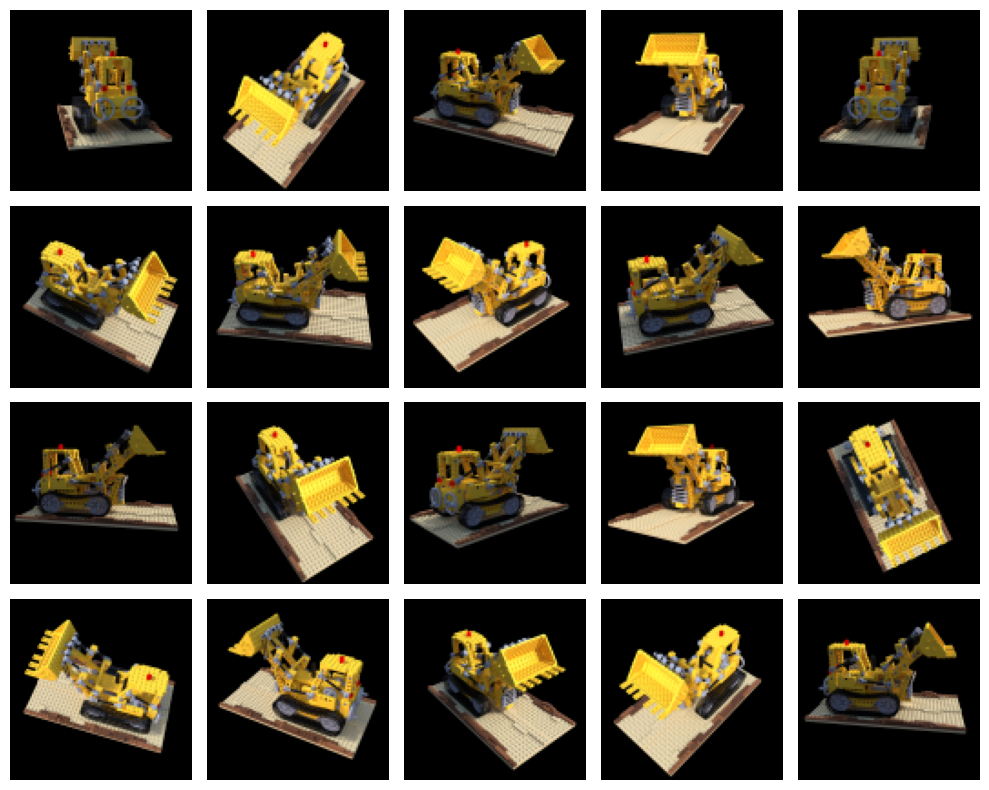

In [57]:
np.random.seed(0)
random_indices = np.random.choice(np.arange(len(images)), 20, replace=False)

# Create a 4x5 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
# Loop over the random indices and plot the corresponding images
for i, index in enumerate(random_indices):
    # Compute the row and column indices for the subplot
    row = i // 5
    col = i % 5
    axes[row, col].imshow(images[index])
    # Turn off the axis labels for a cleaner plot
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

As you can see, the training views are a set of 2D RGB images captured from different viewpoints.

The first step to train a NeRF is to generate rays from the image collection. Let's do this.

In [58]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')

    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

#### Q2.2.1 Ray generation (5 pts)

In your own words, what is each line in the get_rays function doing?

Hint: `c2w` is your 4x4 camera_to_world matrix (stored in the `poses` array defined above). What do the components of (1) `c2w[:3,:3]`, and (2) `c2w[:3,-1]` represent respectively?

Your Answer: Our first line generates a grid of image coordinates of size HxW.  Then we must transform it into our world coordinate system.  We generate a ray, with its origin at the camera, that goes through each point u,v in our coordinates grid.  c2w[:3,:3] represents the rotation of our camera from its initial direction, and c2w[:3,-1] would be the translation of the camera point w.r.t. the world origin.  rays_o reprersents the origin of each ray, and rays_d would indicate the direction.


---

Let's see what do we mean by `ray` and what does it look like in the 3D space.

To save computation budgets for visualization, we first downsample the image.

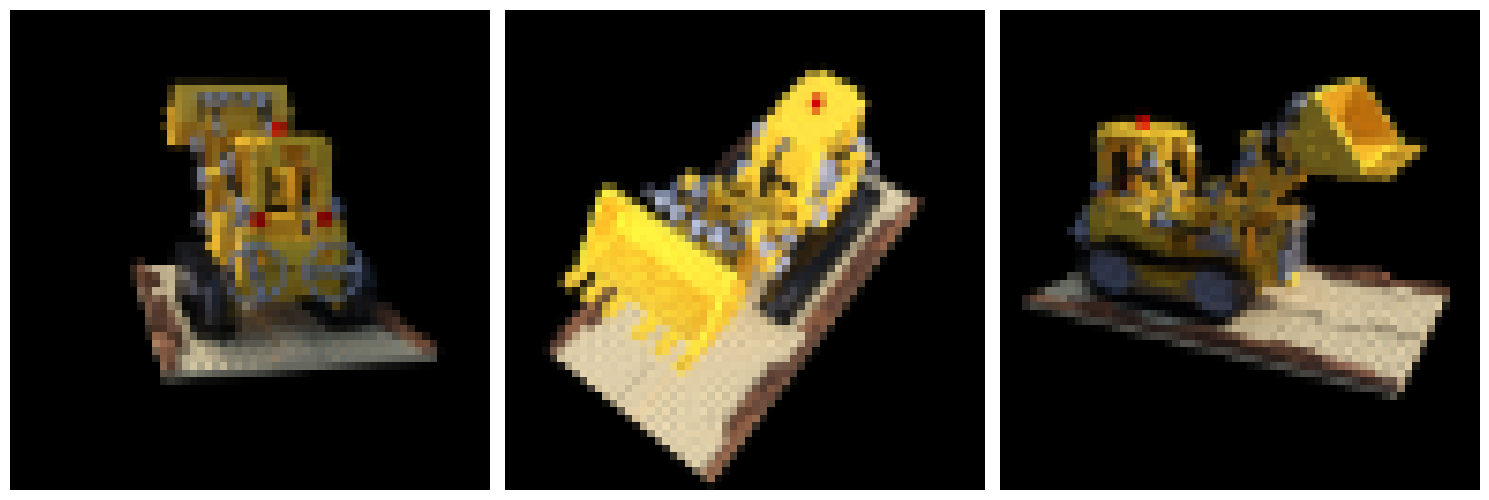

In [59]:
# resize all sampled images to 64x64 for visualization
resized_sample_imgs = np.array([cv2.resize(img, (64, 64)) for img in images[random_indices]])
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(resized_sample_imgs[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

The above images should be very pixelated as we downsampled them significantly.


Here is an implementation of visualizing rays in 3D space.

In [60]:
def vis_camera_rays(rays_o, positions, rgbs=None):
    lines = np.empty((rays_o.shape[0] * 2, 3))
    lines[0::2] = rays_o
    lines[1::2] = positions
    if rgbs is not None:
        colors = np.empty((rays_o.shape[0] * 2, 3))
        colors[0::2] = rgbs
        colors[1::2] = rgbs
    else:
        colors = None
    fig = go.Figure(
        data=go.Scatter3d(
            x=lines[:, 1],
            y=lines[:, 0],
            z=lines[:, 2],
            marker=dict(size=4, color=colors,),
            line=dict(color="lightblue", width=0.1)))
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="x", showspikes=False),
            yaxis=dict(title="z", showspikes=False),
            zaxis=dict(title="y", showspikes=False)),
        margin=dict(r=0, b=10, l=0, t=10),
        hovermode=False)
    return fig

In [61]:
sampled_rays = np.stack([get_rays(64, 64, focal*64/100, pose)
                            for pose in poses[random_indices]], axis=0)
sampled_rays_o = sampled_rays[:, 0, ...].reshape(-1, 3)
sampled_rays_d = sampled_rays[:, 1, ...].reshape(-1, 3)
sampled_rgb = resized_sample_imgs.reshape(-1, 3)
further_sampled = np.random.choice(
    np.arange(sampled_rgb.shape[0]),
    5000, # sampling to many points may crash the entire notebook.
    replace=False)

pixel_unproject_3d_positions = sampled_rays_o + sampled_rays_d
vis_camera_rays(
    sampled_rays_o[further_sampled],
    pixel_unproject_3d_positions[further_sampled],
    sampled_rgb[further_sampled])

Can you see a hemisphere from the plot above? The object should be located in the center of the scene.



#### Q2.2.2 Describe the plot (5 pts)

In your own words, describe what is being plotted above. For instance, what are the different classes (types) of points present in the plot, and how they are obtained?

Your Answer: The single points on the outermost edge are our randomly sampled camera positions.  We call the get rays function for each of these sampled cam_points to generate each of the thin blue lines (our rays) that are emmited from such  points. Each ray begins at the camera point and goes through the sampled image pixels u,v for different views of the object (these generated pixels are the colorful squares that line the outside of the "dome"). Note as well that the distance from each camera to each pixel in the image plane is its "focal distance". The above graph is represented strictly in the +y hemisphere.


---

#### Q2.2.3 Creating our training data (5 pts)


Now, let's get our training rays, and their corresponding pixel values.
Here, we should create a list of training data, where each training example consists of a ray (ray_o, ray_d) and the corresponding RGB value that should be produced.

In [86]:
def get_training_data(H, W, focal, poses, images):
    training_data = None
    ################# Your Implementations #################################
    # 1. First, define the training_rays numpy array. This should consist
    #    of all possible training rays from all training images. As such, the
    #    training_rays array should have dimension
    #      training_rays: np.array with shape  2 x num_images x H x W x 3
    #    Hint: Use np.stack and the get_rays function
    #
    # 2. Next, concatenate this with your training images. You should get an
    #    array of shape 3 x num_images x H x W x 3. Store this array as
    #    training_data
    #    Hint: Use np.concatenate
    training_rays = np.stack([get_rays(H, W, focal*64/100, pose)
                            for pose in poses], axis=1)
    images = np.array([cv2.resize(img, (H, W)) for img in images]).reshape(1, training_rays.shape[1], H, W, 3)

    training_data = np.concatenate([training_rays, images], axis=0)











    ################# End of your Implementations ##########################
    return training_data


If your `training_data` array is defined correctly, the below tests should succeed

In [87]:
for i in [5, 10, 100]:
    assert get_training_data(H, W, focal, poses[:i], images[:i]).shape == (3, i, H, W, 3)
    print(f"Test passed for {i} data points")

Test passed for 5 data points
Test passed for 10 data points
Test passed for 100 data points


Now, let's shuffle our data and use it for training!

In [88]:
training_data = get_training_data(H, W, focal, poses, images)

# Move batch dimension to the start
training_data = np.moveaxis(training_data, 0, -2)
# Reshape the training data to have shape [-1, 3, 3] and shuffle the data
training_data = np.array(np.reshape(training_data, [-1, 3, 3]))
seed_everything(0)
np.random.shuffle(training_data)

# Convert the training data to a NumPy array
training_data = np.asarray(training_data, dtype=np.float32)

#### Q2.2.4 Define SimpleNeRFMLP (8 pts)

Please pay attention to the difference between SimpleNeRFMLP and SimpleMLP (output activation and number of output channels)

In [89]:
import torch.nn as nn
import torch
from torch import optim
class SimpleNeRFMLP(nn.Module):
    def __init__(self, in_dim, net_dim, num_layers):
        super(SimpleNeRFMLP, self).__init__()
        # create a list to store the layers of the MLP
        ############# Your Implementation here #############
        # Your tasks:
        #    1. Create a fc layer with in_dim as input and net_dim as output.
        #    2. Create (num_layers - 2) fc layers, all with `net_dim` in and `net_dim` out,
        #          and ReLU activation function.
        #    3. Create a final fc layer with `net_dim` number of input features
        #         and 4 output features (1 density channel + 3 RGB channels).
        #         ###Don't use any activation here####
        # Hint: You can use torch.nn.Sequential to link your layers together

        self.fc = nn.Sequential(
          nn.Linear(in_dim, net_dim),
          nn.ModuleList([nn.Linear(net_dim, net_dim) for _ in range(num_layers - 2)]),
          nn.Linear(net_dim, 4)
        )

        ############# End of Your Implementation #############


    def forward(self, x):
        out = None
        ############# Your Implementation here #############
        # Implement the forward pass, taking in a coordinate 'x'
        # as input, and returning the density and RGB value for that coordinate
        # in variable 'out'
        out = self.fc(x)

        ############# End of Your Implementation #############
        return out

Take a look at Section 4 (very short) of the NeRF paper here: https://arxiv.org/abs/2003.08934, to have a sense about the rendering function.

In [90]:
def render_rays(
    model, num_freq_bands, rays, near, far, N_samples, rand=False):
    # super long comments...
    """
    Renders an image from 3D rays by first uniformly sampling points along each
    ray, encoding these points using positional encoding, and then computing the
    predicted color and opacity at each point using the given MLP model.

    Args:
    model (nn.Module): MLP model that takes encoded 3D points as input and
            returns the predicted color and opacity.
    num_freq_bands (int): Number of frequency bands used for positional encoding.
    rays (Tuple[torch.Tensor, torch.Tensor]): Tuple containing origin and
        direction of the rays. Both tensors are of shape (num_rays, 3).
    near (float): Near clipping plane distance.
    far (float): Far clipping plane distance.
    N_samples (int): Number of samples along each ray.
    rand (bool): Boolean indicating whether to add random noise to jitter training points.

    Returns:
    Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
    - rgb_map (torch.Tensor): Tensor of shape (num_rays, 3)
          containing the predicted RGB color for each pixel in the image.
    - depth_map (torch.Tensor): Tensor of shape (num_rays, )
          containing the predicted depth for each pixel in the image.
    - acc_map (torch.Tensor): Tensor of shape (num_rays,)
          containing the accumulated alpha (transmittance) for each pixel in the image.
    """
    rays_o, rays_d = rays
    # uniformly sample points in the space from near to far.
    interpolations = torch.linspace(
        near, far, N_samples, device=rays_o.device).repeat(rays_o.shape[0], 1)
    if rand:
        # add random noise to jitter training points
        interpolations += (torch.rand(
            list(rays_o.shape[:-1]) + [N_samples], device=rays_o.device)
                  * (far-near)/N_samples) # we need to scale the noise accordingly

    # sampled pts in 3D space
    pts = rays_o[...,None,:] + rays_d[...,None,:] * interpolations[...,:,None]
    pts_flat = torch.reshape(pts, [-1,3])

    # Apply positional encoding to pts_flat
    pts_flat_freq_encoded = pos_enc(pts_flat, num_freq_bands).float()
    raw = model(pts_flat_freq_encoded)
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities/occupancy and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = torch.nn.functional.relu(sigma_a)
    rgb = torch.sigmoid(rgb)

    # Do volume rendering
    # delta
    dists = torch.cat([interpolations[..., 1:] - interpolations[..., :-1],
                       torch.full_like(interpolations[...,:1], 1e10, device=rays_o.device)], -1)
    # alpha
    alpha = 1.-torch.exp(-sigma_a * dists)
    # transmittance
    trans = torch.where(1 - alpha > 1., 1., 1.-alpha + 1e-10)
    trans = torch.cat([torch.ones_like(trans[...,:1]), trans[...,:-1]], -1)
    # weights
    weights = alpha * torch.cumprod(trans, -1)

    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    acc_map = torch.sum(weights, -1)
    depth_map = torch.sum(weights * interpolations, -1)
    return rgb_map, depth_map, acc_map



Define the train nerf function:

In [91]:
def train_nerf_model(
    model, optimizer, criterion, iters, train_data, device,
    num_freq_bands=8, batch_size=1024, near=2., far=6., N_samples=64):

    seed_everything(0)

    b_i = 0
    psnrs, xs = [], []
    t = time.time()
    # Loop over the specified number of training iterations
    with tqdm(total=iters, desc='train iter') as pbar:
        for i in range(iters):
            # iterate data
            batch = training_data[b_i: b_i + batch_size]
            b_i += batch_size
            rays = torch.moveaxis(torch.tensor(batch[:, :2]).to(device), 1, 0)
            target = torch.tensor(batch[:, 2]).to(device)
            if b_i > training_data.shape[0]:
                b_i = 0

            # Reset the gradients of the optimizer
            optimizer.zero_grad()
            # Forward pass through the model to obtain predictions
            rgb_map, depth_map, acc_map = render_rays(model, num_freq_bands, rays, near, far, N_samples, rand=True)
            # Compute the loss between the predictions and the training data
            loss = criterion(rgb_map, target)

            # Backward pass through the model to compute gradients
            loss.backward()

            # Update the model parameters using the optimizer
            optimizer.step()
            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

            # Every 1000 iterations, compute and store the training and testing PSNRs,
            if i % 1000 == 0 or i == iters:
                model.eval()
                with torch.no_grad():
                  psnr = []
                  # use global val_poses here
                  num_vals = val_poses.shape[0] if i==iters else 1
                  for v in range(num_vals):
                      # Render the holdout view for logging
                      # use global vaiables here
                      rays = get_rays(H, W, focal, val_poses[v,...])
                      rays = torch.tensor(rays).reshape(2, -1, 3)
                      # use chunk trick to overcome GPU OOM issue.
                      num_chunks = 5
                      ray_chunks = torch.chunk(rays, num_chunks, dim=1)

                      for k in range(5):
                          chunk = ray_chunks[k].to(device)
                          rgb_chunk, depth_chunk, acc_chunk \
                              = render_rays(
                                  model, num_freq_bands, chunk, near, far,
                                  N_samples, rand=False)
                          # Merge the results from each chunk back together
                          if k == 0:
                              rgb = rgb_chunk
                              depth = depth_chunk
                              acc = acc_chunk
                          else:
                              rgb = torch.cat((rgb, rgb_chunk), dim=0)
                              depth = torch.cat((depth, depth_chunk), dim=0)
                              acc = torch.cat((acc, acc_chunk), dim=0)
                      rgb = rgb.reshape(100, 100, 3)
                      depth = depth.reshape(100, 100, 1)
                      acc = acc.reshape(100, 100, 1)
                      loss = criterion(rgb, torch.tensor(val_images[v,...], device=device))
                      psnr.append(-10. * torch.log10(loss))
                  print(i, (time.time() - t), 'secs per 1000 iters', 'psnr:', psnr[-1])
                  t = time.time()
                  psnr = torch.mean(torch.tensor(psnr))
                  psnrs.append(psnr)
                  xs.append(i)
                model.train()
    # Return the training and testing results as a dictionary
    return {
        'psnrs': psnrs,
        'xs': xs,
    }


#### Q2.2.5 Compute the input dimension (2 pt)

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 5e-4
iters = 2000
criterion = nn.MSELoss()

num_frequency_bands = 8

input_dim = None
############# Your Implementation here #############
## compute the input_dim


############# End of Your Implementation ###########

model = SimpleNeRFMLP(input_dim, 256, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_nerf_model(model, optimizer, criterion, iters, training_data, device,
    num_freq_bands=num_frequency_bands, batch_size=1024, near=2., far=6., N_samples=64)


TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got NoneType"

Make sure you should get something like:
```
train iter: 100%
2000/2000 [00:50<00:00, 37.05it/s, loss=0.00631]
0 0.618826150894165 secs per 1000 iters psnr: tensor(8.5523, device='cuda:0')
1000 23.76696228981018 secs per 1000 iters psnr: tensor(20.8076, device='cuda:0')
{'psnrs': [tensor(8.5523), tensor(20.8076)], 'xs': [0, 1000]}
```
before continuing

----

Let's define some novel poses for novel view synthesis

In [ ]:
trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]])

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]])

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]])


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

num_render_poses = 100
render_poses = np.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,num_render_poses+1)[:-1]], 0)


In [ ]:
def renderer(model, poses):
    with torch.no_grad():
        rgbs, depths = [], []
        for v in trange(len(poses)):
            # Render the holdout view for logging
            # use global vaiables here
            rays = get_rays(H, W, focal, poses[v])
            rays = torch.tensor(rays).reshape(2, -1, 3)
            # use chunk trick to overcome GPU OOM issue.
            num_chunks = 5
            ray_chunks = torch.chunk(rays, num_chunks, dim=1)

            for k in range(5):
                chunk = ray_chunks[k].to(device)
                rgb_chunk, depth_chunk, acc_chunk \
                    = render_rays(
                        model, 8, chunk, 2., 6.,
                        64, rand=False)
                rgb_chunk = rgb_chunk.detach().cpu()
                depth_chunk = depth_chunk.detach().cpu()
                acc_chunk = acc_chunk.detach().cpu()
                # Merge the results from each chunk back together
                if k == 0:
                    rgb = rgb_chunk
                    depth = depth_chunk
                    acc = acc_chunk
                else:
                    rgb = torch.cat((rgb, rgb_chunk), dim=0)
                    depth = torch.cat((depth, depth_chunk), dim=0)
                    acc = torch.cat((acc, acc_chunk), dim=0)
            rgb = rgb.reshape(100, 100, 3)
            depth = depth.reshape(100, 100, 1)
            rgbs.append(rgb)
            depths.append(depth)
        return rgbs, depths

Render novel views

In [ ]:
rgbs, depths = renderer(model, render_poses)

In [ ]:
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

# Define the output video file path
imageio.mimwrite('2k_video.mp4', to8b(np.stack(rgbs)), fps=10, quality=8)


mp4 = open('2k_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

You results should look really bad as MLP-based NeRFs usually require long training.

---

Now, let's train longer


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 5e-4
iters = 50000
criterion = nn.MSELoss()

num_frequency_bands = 8

model = SimpleNeRFMLP(input_dim, 256, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_nerf_model(model, optimizer, criterion, iters, training_data, device,
    num_freq_bands=num_frequency_bands, batch_size=1024, near=2., far=6., N_samples=64)


In [ ]:
rgbs, depths = renderer(model, render_poses)

imageio.mimwrite('50k_video.mp4', to8b(np.stack(rgbs)), fps=10, quality=8)

mp4 = open('50k_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

You should obtain improved results here